# Fuse multiple chunks and run the Poisson reconstruction

This notebook aims at fusing a few chunks of data together and creating a mesh using screened Poisson reconstruction.

We start by importing a few libraries, then plotting the cropping boxes. 

In [1]:
import json
import os
import numpy as np 
import matplotlib.pyplot as plt
import cloudComPy as cc # cloud compare python interface.

if cc.isPluginCSF():
    import cloudComPy.CSF


from subprocess import run

from yaml import load
from yaml.loader import Loader

from helpers.utils import plot_segmentation_scheme

In [2]:
caveName = "10_Lauiloch"
SCAN = 0
root = f"../../real_data/{caveName}"

PROCESSING_FILEPATH = os.path.normpath(os.path.join(root, "params.yaml"))
p = load(open(PROCESSING_FILEPATH), Loader)

SCAN_NAME = p['paths']['scanNames'][SCAN]
shift = p["alignment"]["globalShift"]

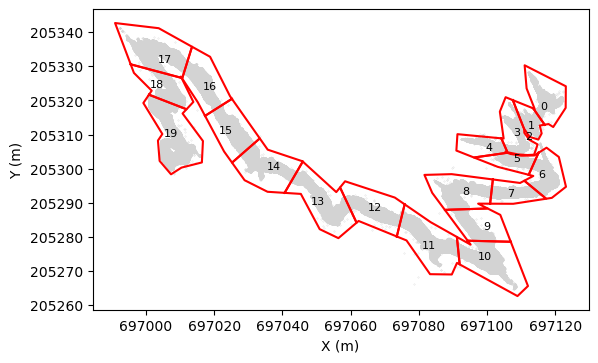

In [3]:
fig, ax = plt.subplots()

ax, res = plot_segmentation_scheme(root, ax, scan=SCAN)

plt.xlabel("X (m)")
plt.ylabel("Y (m)")

plt.show()

In [4]:
# now select the segments we want to fuse together. 
SEGMENTS = np.arange(3, 20)

toBeFused = [0, 1] + list(SEGMENTS)

suffix = [str(i) for i in toBeFused]

In [5]:
fp = os.path.normpath(os.path.join(root, "process/cropped_clouds/", "{scan_name}_Cropped_{i}_normals_reoriented.ply"))

In [6]:
paths = [fp.format(i=i, scan_name = SCAN_NAME) for i in toBeFused]

In [7]:
paths[0]

'..\\..\\real_data\\10_Lauiloch\\process\\cropped_clouds\\EntranceGallery_Cropped_0_normals_reoriented.ply'

In [8]:
cloud = cc.loadPointCloud(paths[0], cc.CC_SHIFT_MODE.XYZ, 0, *shift)

In [9]:
for c,(segment,fp) in enumerate(zip(toBeFused, paths)):
    cloud = cc.loadPointCloud(paths[c], cc.CC_SHIFT_MODE.XYZ, 0,  *shift)
    ground, _ = cc.CSF.computeCSF(cloud, csfRigidness= 1, maxIteration=500, clothResolution= 0.02, classThreshold= 0.25)

    ground.setName(f"{SCAN_NAME}_{segment}")
    _ = cc.SavePointCloud(ground, os.path.join(root, f"{SCAN_NAME}/output/ground/ground_{segment}.ply"))

    ground_raster =  cc.RasterizeGeoTiffOnly(ground, 
                                            gridStep= 0.02,
                                            vertDir=cc.CC_DIRECTION.Z,
                                            outputRasterZ=True,
                                            pathToImages=os.path.join(root, f"{SCAN_NAME}/output/"),
                                            emptyCellFillStrategy=cc.EmptyCellFillOption.LEAVE_EMPTY)